October: Part 2 - This notebook is a continuation of gyre_runs.ipynb, with specific interest in Mackenzie Canyon runs. The configuration used to produce these results is gyre_mackenzie01. Parameters explored: ln_bt_nn_auto, rn_rdt, nn_baro, rn_bt_cmax, nn_itend, nn_write, nn_tau0, rn_utau0, rn_vtau0, jperio, cp_cfg.

In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from IPython.display import Image, display
import glob
from salishsea_tools import nc_tools
%matplotlib inline

In [2]:
def load_gyre_output(path, cfg):
    gridT = nc.Dataset(glob.glob(path + cfg + '/GYRE_*_grid_T.nc')[0])
    gridU = nc.Dataset(glob.glob(path + cfg + '/GYRE_*_grid_U.nc')[0])
    gridV = nc.Dataset(glob.glob(path + cfg + '/GYRE_*_grid_V.nc')[0])
    gridW = nc.Dataset(glob.glob(path + cfg + '/GYRE_*_grid_W.nc')[0])

    lon = gridT.variables['nav_lon']
    lat = gridT.variables['nav_lat']
    tem = gridT.variables['votemper']
    sal = gridT.variables['vosaline']
    ssh = gridT.variables['sossheig']
    U = gridU.variables['vozocrtx']
    V = gridV.variables['vomecrty']
    W = gridW.variables['vovecrtz']
    return gridT, lon, lat, tem, sal, ssh, U, V, W

In [3]:
def plot_gyre_times(gridT, var, time_inds, cmin, cmax, cmaps, max_min):
    fig, ax = plt.subplots(1, len(time_inds), figsize=(20, 4), sharex=True, sharey=True)
    for i, n in zip(time_inds, np.arange(len(time_inds))):
        if max_min == True:
            c = ax[n].pcolormesh(var[i,9,:,:], cmap=cmaps, vmin = cmin, vmax = cmax) # depth = 135.84467 m
        elif max_min == False:
            c = ax[n].pcolormesh(var[i,9,:,:], cmap=cmaps)
            cbar = fig.colorbar(c, ax=ax[n])
        timestamp = nc_tools.timestamp(gridT,i)
        ax[n].set_title(timestamp)
        ax[n].set_xlim(0,U.shape[3])
        ax[n].set_ylim(0,U.shape[2])
    cbar = fig.colorbar(c, ax=ax[0])
    return fig

# Run 01
### Reduced time step
This set of runs shows the effect of reducing the baroclinic timestep (10 seconds), adjusting the frequency of output writing (1 hour), and turning off the wind stress applied. The very small velocities can be attributed to the T and S gradients across partial steps. It uses bathy_mackenzie02.nc and coords_mack05.nc (100 x 100).

| Parameters|    1 |   2 |   3   |  4    |   5 |  6 |   7  |   8  | 9 |     10   |   11 |     12   |13  |14  |
|:---------:|:-----:|:---:|:-----:|:-----:|:----:|:--:|:----:|:----:|:-:|:------:|:----:|:--------:|:--:|:--:|
| rn_rdt    | 2 h  | 2 h |**8 h**|**3 m**| -   | -  | -    | 15 s | - |**10 s**| 2 h  | **10 s**|test|test|
| nn_itend  | 360 d| 10 d| 352 d | 1 d   | -   | -  | -    | 6 h  | - | 6 h      | 360 d| 6 h      |cfg |new |
| nn_write  | 5d   | -   | -     | -     | -   | -  | -    | -    | - | 6 h      | 5 d  | 1 h      |from|bathy|
| nn_tau000 | 100  | -   | -     | -     | -   | 20 | -    | -    | - | 20       | 100  | 100      |ref|and  |
| ztau      | 0.105| -   | -     | -     | 0.01| -  | -    | -    | 0 | 0        | **0**| **0**   |  |coords|
| ztau_sais | 0.015| -   | -     | -     | -   | -  | 0.001| -    | 0 | 0        | **0**| **0**   |  |  |
| kt        | 1    | 1   | 3     | 9     | 9   | 9  | 9    | X    | 1 | ✓*       | X    | ✓!       |✓!|✓*|

1. \* (gyre runs but no output files) ! (gyre runs and produces output)
2. kt = ocean time step - in this table, at which the model explodes
3. The spacing ratio tells me the timestep ratio should be 3 m
4. The timestep in nemo must be an even number
5. Reducing the forcing to zero isn't enough, you need to lower the timestep

Re-run: Added namsplit from namelist_ref into namelist_cfg and, as expected, no change.

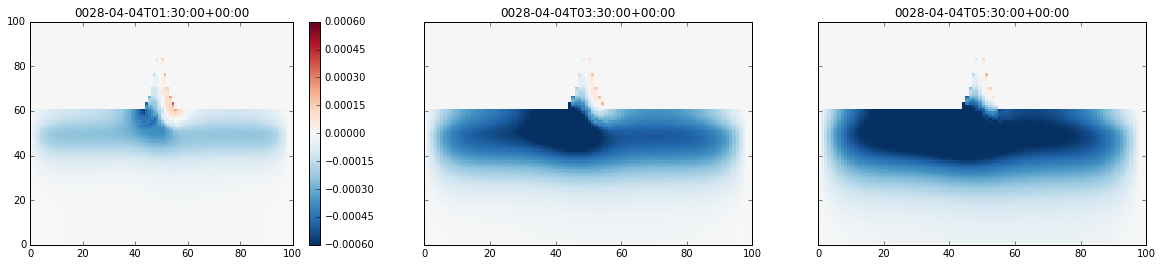

In [4]:
path = '/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/'
cfg = 'gyre_mackenzie01/EXP00/Run01'
gridT, lon, lat, tem, sal, ssh, U, V, W = load_gyre_output(path, cfg)
fig = plot_gyre_times(gridT, U, [1,3,5], -0.0006, 0.0006, cm.RdBu_r, True) # -0.0006 0.0003

# Run 02
### Coarser resolution, new coordinates process
This run has the same settings as Run01 except that it uses a different bathymetry and coordinates file. The coordinates file comes from the great circle process. Refer to set of parameters # 14 in the table above. It uses bathy_mackenzie03.nc and coords_mack06.nc (72 x 97).

grid_mack06.nc = 100 x 75

coords_mack06.nc = 72 x 97

bathy_mackenzie03.nc = 97 x 72

Need to figure out what happens when it goes through matlab script. I got it to work by flipping bathy.

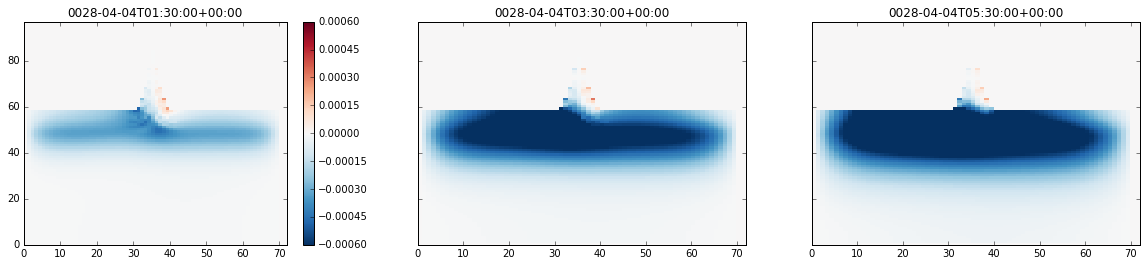

In [5]:
path = '/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/'
cfg = 'gyre_mackenzie01/EXP00/Run02'
gridT, lon, lat, tem, sal, ssh, U, V, W = load_gyre_output(path, cfg)
fig = plot_gyre_times(gridT, U, [1,3,5], -0.0006, 0.0006, cm.RdBu_r, True) # -0.0004  0.00024

# Baroclinic and Barotropic Timesteps

* Baroclinic = rn_rdt (seconds)
* Barotropic = nn_baro (iterations)
* Max Courant = rn_bt_cmax (value)

### CFL Condition
Barotropic:

$$u = \sqrt{gH}$$
___
$$\frac{\Delta t}{\Delta x} \leq \frac{C_{max}}{u}$$

$$iterations = \frac{\Delta t_{baroclinic}}{\Delta t_{barotropic}}$$
___

$$\frac{\Delta t_{barotropic}}{\Delta x} \leq \frac{rn\_bt\_cmax}{u}$$

$$nn\_baro = \frac{rn\_rdt}{\Delta t_{barotropic}}$$

In [6]:
# Salish Sea Settings
dt_tropic = 2; dx = 500; H = 430; dt_clinic = 40

g = 9.81
u = np.sqrt(g * H)
Cmax = (dt_tropic * u) / dx
iterations = dt_clinic / dt_tropic
Cmax, iterations

(0.25979376435934715, 20.0)

In [7]:
# Mackenzie Canyon Settings (Run02)
# Automatically sets iterations defined by max courant number
Cmax = 0.8 ; dx = 4247 ; H = 1300; dt_clinic = 10
u = np.sqrt(g * H)
dt_tropic = (Cmax * dx) / u
iterations = dt_clinic / dt_tropic
dt_tropic, iterations

(30.086112016703975, 0.33237927168681497)

In [8]:
Cmax = 0.13 ; dx = 4247 ; H = 1300; dt_clinic = 30
u = np.sqrt(g * H)
dt_tropic = (Cmax * dx) / u
iterations = dt_clinic / dt_tropic
dt_tropic, iterations

(4.8889932027143956, 6.1362327080642771)

In [9]:
dx = 4247 ; H = 1300; dt_clinic = 30; iterations = 6
dt_tropic = dt_clinic / iterations
Cmax = (dt_tropic * u) / dx
Cmax, dt_tropic

(0.132951708674726, 5.0)

* If True, NEMO calculates nn_baro using cmax.
* If False, you need to give it nn_baro. 

|Parameters   | 1   | 2   | 3   | 4   | 5   | 6   | 7   | 8   |
|-------------|-----|-----|-----|-----|-----|-----|-----|-----|
|ln_bt_nn_auto|False|False|False|True |True |True |False|False|
|rn_rdt       |40   |40   |40   |40   |40   |10   |20   |30   |
|nn_baro      |4    |4    |5    |---  |---  |---  |4    |6    |
|calc nn_baro |---  |---  |---  |4    |21   |5    |---  |---  |
|rn_bt_cmax   |---  |---  |---  |0.25 |0.05 |0.05 |---  |---  |
|calc cmax    |0.26 |0.26 |0.21 |---  |---  |---  |0.13 |0.13 |
|calc dt_trop |10   |10   |8    |9    |1    |1    |5    |5    |
|kt           |34   |34   |34   |34   |34   |✓    |✓    |59   |

Parameters left in the code but not used by code:
* rn_bt_cmax for 1, 2, 3, 7, 8  = 0.8, 0.25, 0.25, 0.05, 0.13
* nn_baro for 4, 5, 6 = 5, 5, 5

# Run03
### Defined barotropic iterations
This run tests the distinction between the baroclinic and barotropic timestep by supplying nn_baro (barotropic iterations) as in parameter set 7. 

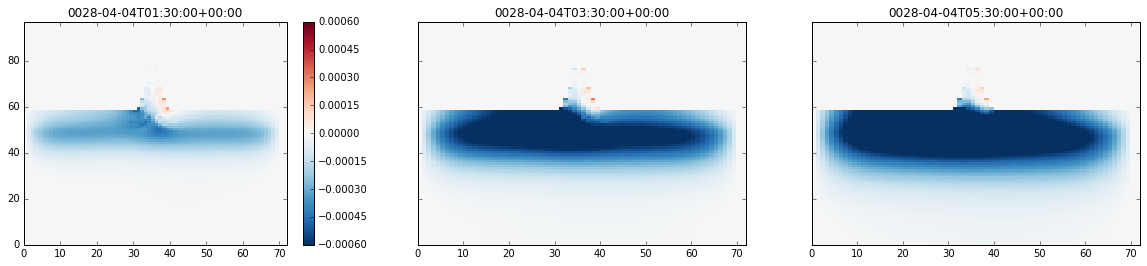

In [10]:
path = '/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/'
cfg = 'gyre_mackenzie01/EXP00/Run03'
gridT, lon, lat, tem, sal, ssh, U, V, W = load_gyre_output(path, cfg)
fig = plot_gyre_times(gridT, U, [1,3,5], -0.0006, 0.0006, cm.RdBu_r, True) # -0.0004 0.00024

# Ocean Forcing Analytical vs Gyre

#### sbcmod.F90 [subroutine: sbc_init]

    IF( cp_cfg == 'gyre' ) THEN            ! GYRE configuration
              ln_ana      = .TRUE.   
              nn_ice      =   0
             
<font color='MidnightBlue'>namelist_cfg, subroutine namcfg, has cp_cfg = "gyre". The subroutine namsbc has nn_fsbc(1), ln_ana (true), ln_blk_core (false), nn_ice (0), ln_rnf = false, ln_ssr = false, nn_fwb = 0. Additionally, subroutine namsbc_ana has nn_tau000 (100) and rn_utau0 (0.1e0)</font>
              
    IF(lwp) THEN
         WRITE(numout,*) 'sbc_init : surface boundary condition setting'
      ENDIF
      
    IF(lwp) THEN  
    WRITE(numout,*) 'frequency update of sbc (and ice) nn_fsbc = ', nn_fsbc
    WRITE(numout,*) 'analytical formulation ln_ana = ', ln_ana
                    ... a bunch of parameters ...
    WRITE(numout,*) 'n. of iterations if land-sea-mask applied  nn_lsm= ', nn_lsm

<font color='MidnightBlue'>namelist_ref, subroutine namcfg, has cp_cfg = "default". The subroutine namsbc lists all of the parameters that are listed in the "lwp" case in sbcmod. The subroutine namsbc_ana more parameters listed than namelist_cfg as well, but these are not listed in sbcmod.</font>

#### sbcana.F90 [subroutine: sbc_gyre and sbc_ana]
sbc_gyre

    WRITE(numout,*)'sbc_gyre : analytical surface fluxes for GYRE conf'               
    WRITE(numout,*)'           nyear      = ', nyear
                    ... a bunch of parameters ...
    WRITE(numout,*)'           ndastp     = ', ndastp
    WRITE(numout,*)'           adatrj     = ', adatrj

<font color='MidnightBlue'>In ocean.output, this list of parameters is printed when cp_cfg = 'gyre' in namelist_cfg.</font>

sbc_ana

    IF(lwp) WRITE(numout,*)'sbc_ana : Constant surface fluxes read in namsbc_ana namelist'
    IF(lwp) WRITE(numout,*)'spin up of the stress nn_tau000 = ', nn_tau000, ' time-steps'
                    ... rn_utau0, rn_vtau0, rn_qns0, rn_qsr0 ...
    IF(lwp) WRITE(numout,*)'net heat flux rn_emp0   = ', rn_emp0  , ' Kg/m2/s
    
<font color='MidnightBlue'>In ocean.output, this list is printed when cp_cfg = 'test', for example.</font>    

# Run04
### Analytical instead of Gyre formulation
This run simply changes the name of the configuration from "gyre" to "test" in order to get the forcing from sbc_ana instead of sbc_gyre. One of the components of stress is zero, while the other is 0.1 Nm$^{-2}$, and it takes a long time to reach the nominal value.

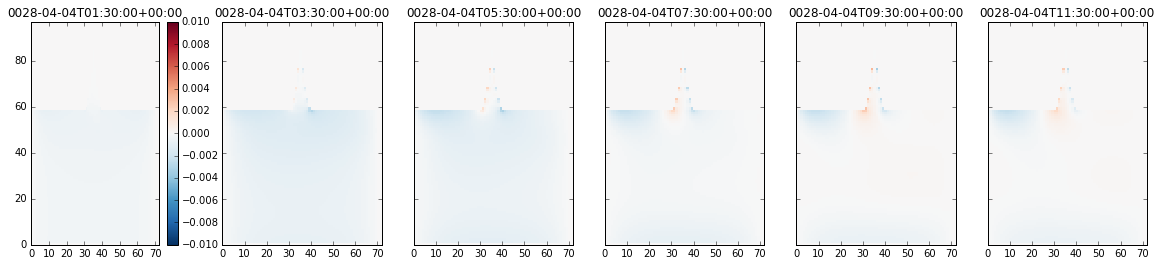

In [11]:
path = '/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/'
cfg = 'gyre_mackenzie01/EXP00/Run04'
gridT, lon, lat, tem, sal, ssh, U, V, W = load_gyre_output(path, cfg) 
fig = plot_gyre_times(gridT, U, [1,3,5,7,9,11], -0.01, 0.01, cm.RdBu_r, True) # -0.0007 0.0018

# Analytical Forcing

* nn_tau000 = nb of time-step during which the surface stress increase from 0 to its nominal value     
* rn_utau0 = constant wind stress value in i-direction
* rn_vtau0 = constant wind stress value in j-direction

|Parameter|Run04     |Run05|Run06   |Run07|Run08|
|---------|----------|-----|--------|-----|-----|
|nn_tau000|100       |0    |540 (3h)|---  |---  |
|rn_utau0 |0.1       |0.5  |0.5     |5.0  |---  |
|rn_vtau0 |0         |0.5  |0.5     |5.0  |---  |
|rn_rdt   |20        |---  |---     |---  |---  |
|nn_itend |2160 (12h)|---  |---     |---  |---  |
|nn_write |360 (2h)  |---  |---     |---  |---  |
|jperio   |0         |---  |---     |---  |1    ||

# Run05
### Different wind stress values
This run implements a wind stress of 0.5 Nm$^{-2}$ in both directions. The stress reaches its nominal value from the start.

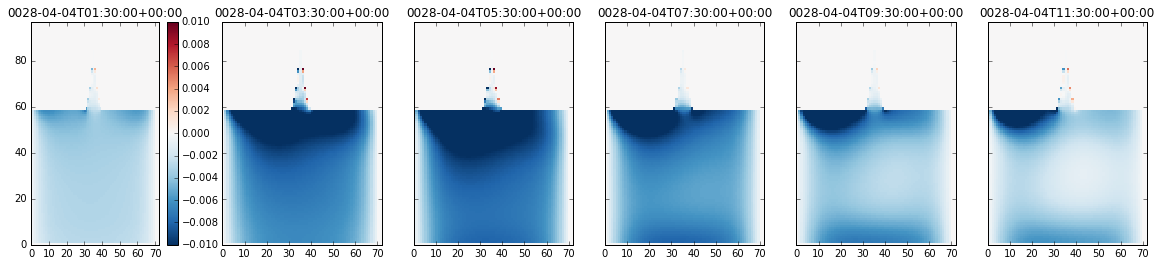

In [12]:
path = '/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/'
cfg = 'gyre_mackenzie01/EXP00/Run05'
gridT, lon, lat, tem, sal, ssh, U, V, W = load_gyre_output(path, cfg) 
fig = plot_gyre_times(gridT, U, [1,3,5,7,9,11], -0.01, 0.01, cm.RdBu_r, True) # -0.006 0.01

# Run06
### Different wind stress duration
This run implements a wind stress of 0.5 Nm$^{-2}$ in both directions. It takes 3 hours for the stress to reach its nominal value.

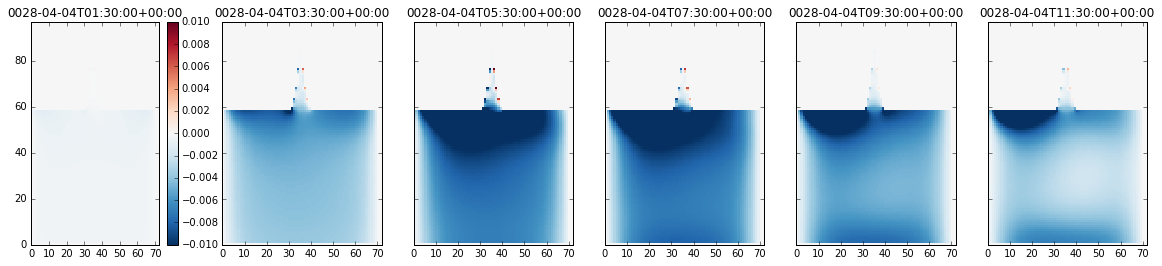

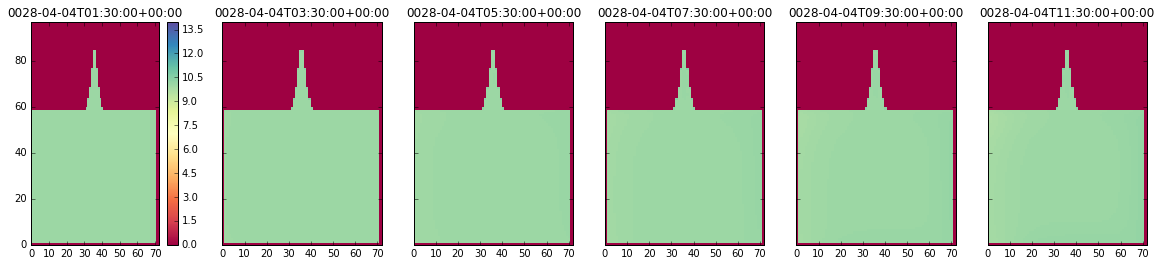

In [13]:
path = '/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/'
cfg = 'gyre_mackenzie01/EXP00/Run06'
gridT, lon, lat, tem, sal, ssh, U, V, W = load_gyre_output(path, cfg) 
fig = plot_gyre_times(gridT, U, [1,3,5,7,9,11], -0.01, 0.01, cm.RdBu_r, True) # -0.001 0.01
fig = plot_gyre_times(gridT, tem, [1,3,5,7,9,11], 0, 14, cm.Spectral, True)

# Run07
### Large wind stress values
The nominal value for the stresses are greater in this run at 5.0 Nm$^{-2}$. It still takes 3 hours to increase to that value. We finally see changes in a tracer field, temperature. Nothing visible at this depth for salinity.

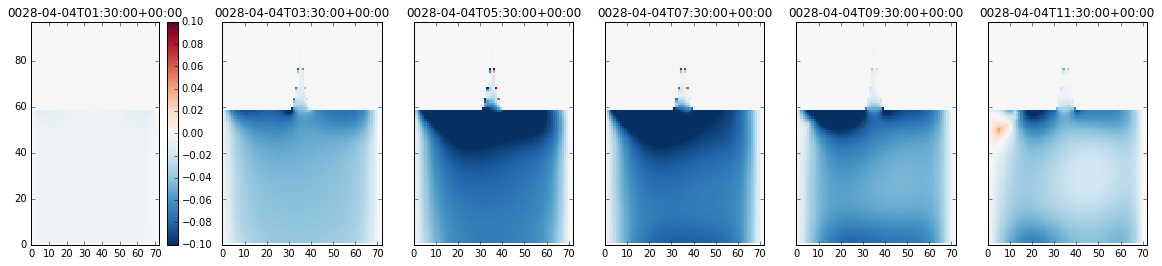

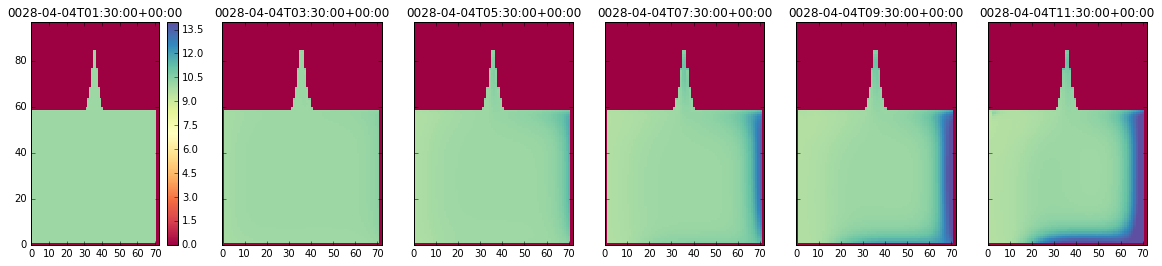

In [14]:
path = '/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/'
cfg = 'gyre_mackenzie01/EXP00/Run07'
gridT, lon, lat, tem, sal, ssh, U, V, W = load_gyre_output(path, cfg) 
fig = plot_gyre_times(gridT, U, [1,3,5,7,9,11], -0.1, 0.1, cm.RdBu_r, True) # -0.25 0.1
fig = plot_gyre_times(gridT, tem, [1,3,5,7,9,11], 0, 14, cm.Spectral, True)

# Model Domain Boundary Condition

The choice of closed, cyclic or symmetric model domain boundary condition is made by setting ```jperio``` to 0, 1, or 2 in namcfg. This calls the routine lbclnk.F90.

* Closed boundary: First and last rows and columns are set to zero.
* Cyclic east-west boundary: First and last rows are set to zero. First and second columns are set to the values of the penultimate and last columns.

The gyre configuration has closed boundaries by default.

# Run08
### Periodic Boundaries
Like Run07, the stresses are 5.0 Nm$^{-2}$ and take 3 hours to increase. The boundaries were changed from closed to periodic.

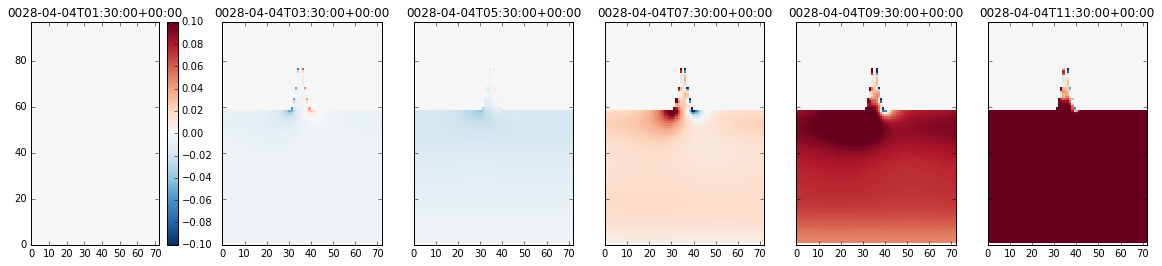

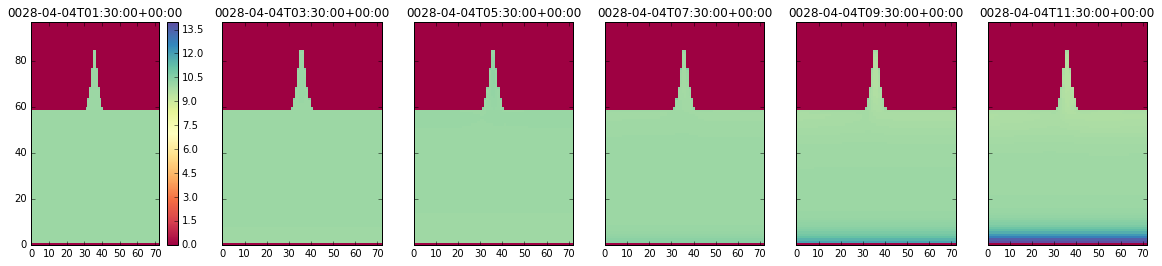

In [6]:
path = '/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/'
cfg = 'gyre_mackenzie01/EXP00/Run08'
gridT8, lon8, lat8, tem8, sal8, ssh8, U8, V8, W8 = load_gyre_output(path, cfg) 
fig = plot_gyre_times(gridT8, U8, [1,3,5,7,9,11], -0.1, 0.1, cm.RdBu_r, True) # -0.16 0.48
fig = plot_gyre_times(gridT8, tem8, [1,3,5,7,9,11], 0, 14, cm.Spectral, True)